In [1]:
import os
import csv
import warnings
import itertools

from scipy import linalg
from sklearn.cluster import KMeans, DBSCAN

import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

In [2]:
data = [x[0] for x in os.walk('data')][0]

In [3]:
authors = {}
new_author_ids = {}
new_author_ids_rev = {}

with open(f"{data}/authors.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)

    i = 0
    for row in reader:
        id_, name = row
        new_author_ids[i] = int(id_)
        new_author_ids_rev[int(id_)] = i
        authors[int(id_)] = name
        i += 1


In [4]:
len(authors.keys()), list(authors.items())[:10]

(8653,
 [(1, 'Hisashi Suzuki'),
  (10, 'David Brady'),
  (100, 'Santosh S. Venkatesh'),
  (1000, 'Charles Fefferman'),
  (1001, 'Scott Markel'),
  (1002, 'Gregory J. Wolff'),
  (1003, 'Timothy W. Cacciatore'),
  (1004, 'Paul Sajda'),
  (1005, 'Leif H. Finkel'),
  (1006, 'Arun K. Jagota')])

In [5]:
paper_authors = {}

with open(f"{data}/paper_authors.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        id_, paper_id, author_id = map(int, row)
        author_id = new_author_ids_rev[author_id]
        if paper_id in paper_authors:
            paper_authors[paper_id].append(author_id)
        else:
            paper_authors[paper_id] = [author_id]

In [6]:
len(paper_authors.keys()), list(paper_authors.items())[:10]

(6557,
 [(63, [8592]),
  (80, [253, 264, 275, 286]),
  (9, [319]),
  (20, [2526, 2637, 2748]),
  (66, [8643, 2]),
  (3, [1665, 6120]),
  (71, [85, 95]),
  (83, [331]),
  (82, [320]),
  (24, [3304, 319])])

compute adjaency W matrix

In [7]:
W = np.diag(np.ones(len(authors.keys())))

In [9]:
num_edges = 0

for paper, authors_ in paper_authors.items():
    if len(authors_) >= 2:
        for i1, i2 in itertools.permutations(authors_, 2):
            if W[i1, i2] > 0:
                W[i1, i2] *= 2
            else:
                W[i1, i2] = 1
            num_edges += 1

num_edges

43634

built-in Kmeans

In [10]:
D = np.diag(np.sum(W, axis=1))

L = D - W

eigvals, eigvecs = np.linalg.eigh(L)

k = 50
selected_eigvecs = eigvecs[:, :k]

kmeans = KMeans(n_clusters=k).fit(selected_eigvecs)

clusters = kmeans.labels_


In [11]:
G = nx.from_numpy_array(W)

In [26]:
clusters_dict = {i: np.where(clusters == i)[0] for i in range(k)}

centers = {}
communities = {}
G_main_com = G.copy()
min_nb = 30

for com, list_nodes in clusters_dict.items():
    if len(list_nodes) < min_nb:
        G_main_com.remove_nodes_from(list_nodes)
    else:
        H = G_main_com.subgraph(list_nodes)
        d_c = nx.degree_centrality(H)
        center = max(d_c, key=d_c.get)
        centers[center] = com
        communities[com] = center


In [ ]:
plt.figure(figsize=(13, 9))
node_size = 50
count = 0
pos = nx.spring_layout(G_main_com)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))


In [34]:
new_communities = {x: authors[new_author_ids[communities[x]]] for x in communities.keys()}

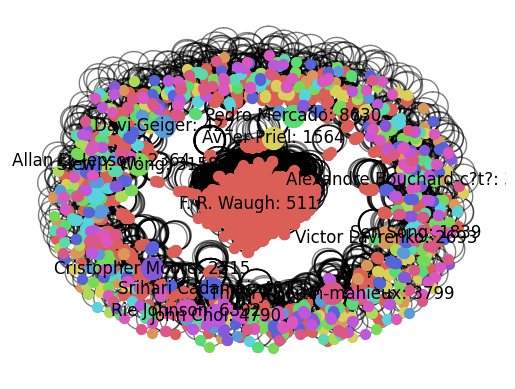

In [33]:
for com, list_nodes in clusters_dict.items():
    count = count + 1
    try:
        non_center_nodes = [node for node in list_nodes if node != communities[com]]
    except KeyError:
        continue
    nx.draw_networkx_nodes(G_main_com, pos, non_center_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_main_com, pos, [communities[com]], node_size = node_size*5, node_color = colors[com])

nx.draw_networkx_edges(G_main_com, pos, alpha=0.5)
labels = {k: str(new_communities[v]) + ': ' + str(k) for k,v in centers.items()}
nx.draw_networkx_labels(G_main_com, pos, labels)
plt.axis('off')
plt.show()

# Approach 1: Unnormalized Spectral Clustering

Input: Similarity matrix S ∈ n×n, number k of clusters to construct.
- Construct a similarity graph. Let $W$ be its weighted adjacency matrix.
- Compute the unnormalized Laplacian $L$.
- Compute the first $k$ eigenvectors $u_1,...,u_k$ of $L$.
- Let $U ∈ n×k$ be the matrix containing the vectors $u_1,...,u_k$ as columns.
- For $i = 1,...,n$, let $y_i ∈ k$ be the vector corresponding to the i-th row of $U$.
- Cluster the points $(y_i)i=1,...,n$ in $k$ with the k-means algorithm into clusters $C_1,...,C_k$. </br></br>
Output: Clusters $A_1,...,A_k$ with $A_i = \{j| y_j ∈ C_i\}$.

In [8]:
def create_similarity_matrix():
    W = np.diag(np.ones(len(authors.keys())))
    num_edges = 0
    for paper, authors_ in paper_authors.items():
        if len(authors_) >= 2:
            for i1, i2 in itertools.permutations(authors_, 2):
                if W[i1, i2] > 0:
                    W[i1, i2] *= 2
                else:
                    W[i1, i2] = 1
                num_edges += 1

    return W

def create_unnormalized_laplacian(W):
    degree_values = np.sum(W, axis=1)
    D = np.diag(degree_values)
    L = D - W
    return L

def compute_U_matrix(L, k):
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    k = 100
    U = eigenvectors[:, :k]

    return U

def get_y_vectors(U):
    y_vectors = []
    for i in range(U.shape[0]):
        y_i = U[i, :]
        y_vectors.append(y_i)
        
    return np.array(y_vectors)

def cluster_points_kmeans(y_vectors, k):
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(y_vectors)

    return clusters

def cluster_points_dbscan(y_vectors, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(y_vectors)

    return clusters

In [16]:
def plot_largest_cluster(G, clusters, big_clusters):
    clusters_dict = {i: np.where(clusters == i)[0] for i in big_clusters[0]}
    clusters_dict_names = {}

    for key, vals in clusters_dict.items():
        new_vals = []
        for v in vals:
            new_id = new_author_ids[v]
            new_vals.append(authors[new_id])

        clusters_dict_names[key] = new_vals

    centers = {}
    communities = {}
    new_communities = {}
    G_main_com = G.copy()
    min_nb = 30

    for com, list_nodes in clusters_dict.items():
        if len(list_nodes) < min_nb:
            G_main_com.remove_nodes_from(list_nodes)
        else:
            H = G_main_com.subgraph(list_nodes)
            d_c = nx.degree_centrality(H)
            if not d_c:
                print(com, list_nodes)
            center = max(d_c, key=d_c.get)
            centers[center] = com
            communities[com] = center
            new_communities[com] = authors[new_author_ids[center]]
            
            print('Community of ', center , '(ID ', com, ') - ', len(list_nodes), ' authors:')
            print(clusters_dict_names[com], '\n')

    return G_main_com, clusters_dict, communities, new_communities, centers

def display_graph(G, clusters, big_clusters):
    G_main_com, clusters_dict, communities, new_communities, centers = plot_largest_cluster(G, clusters, big_clusters)
    plt.figure(figsize=(13, 9))
    node_size = 50
    count = 0
    pos = nx.spring_layout(G_main_com)
    colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))
    for com, list_nodes in clusters_dict.items():
        count = count + 1
        try:
            non_center_nodes = [node for node in list_nodes if node != communities[com]]
        except KeyError:
            continue
        nx.draw_networkx_nodes(G_main_com, pos, non_center_nodes, node_size = node_size, node_color = colors[com])
        nx.draw_networkx_nodes(G_main_com, pos, [communities[com]], node_size = 1, node_color = colors[com])

    labels = {k: str(new_communities[v]) + ': ' + str(k) for k,v in centers.items()}
    nx.draw_networkx_labels(G_main_com, pos, labels)
    plt.axis('off')
    plt.show()


In [216]:
k = 1000
W = create_similarity_matrix()
L = create_unnormalized_laplacian(W)
U = compute_U_matrix(L, k)
y_vectors = get_y_vectors(U)

## Cluster with KMeans

In [217]:
clusters = cluster_points_kmeans(y_vectors, k)

In [218]:
cluster_lens = np.empty(k)

for i in range(k):
    cluster_lens[i] = len(np.where(clusters == i)[0])

max(cluster_lens), min(cluster_lens), np.mean(cluster_lens)

(308.0, 0.0, 8.653)

In [219]:
G = nx.Graph(W)

In [220]:
big_clusters = np.where(cluster_lens > 30)
big_clusters

(array([  0,   1,  33,  50,  68,  83,  89, 116, 181, 258, 261, 296, 326,
        351, 353, 481, 510, 528, 544, 563, 572, 575, 578, 587, 733, 801,
        803, 809, 814, 820, 830, 835, 837, 838, 853, 862, 877, 878, 880,
        882, 895, 898, 936, 938, 945, 949, 951, 954, 959, 960, 962, 977],
       dtype=int64),)

Community of  4362 (ID  0 ) -  75  authors:
['Richard H. Lathrop', 'Rafael Malach', 'Geoffrey B. Jackson', 'Alan A. Stocker', 'N. S. Skantzos', 'Jason Weston', 'Alfonso Renart', 'Simon Tong', 'Hans-Ulrich Simon', 'Predrag Neskovic', 'Quaid D. Morris', 'Sean Stromsten', 'Adam Spiro', 'John Blitzer', 'John Hopfield', 'Guy Shani', 'Dmitry Volkinshtein', 'Maxim Raginsky', 'Steven Rennie', 'Chuong B. Do', 'Markus Maier', 'Ronald Ortner', 'Mingjun Zhong', 'Yoshinobu Kawahara', 'Yi Mao', 'Paul Rigor', 'Philip Bradley', 'Claudia Clopath', 'Alekh Agarwal', 'William D. Smart', 'Zenglin Xu', 'Brian Kulis', 'Haixuan Yang', 'Lukas Kroc', 'Matthew Streeter', 'Clark Glymour', 'Lei Wang', 'Adam Fleisher', 'Alan Jern', 'Feng Yan', 'Bernhard E. Boser', 'Michael James', 'Andrew Wilson', 'Takashi Washio', 'Yann N. Dauphin', 'Charles A. Sutton', 'Kee-eung Kim', 'Junming Yin', 'Pablo Mus?', 'Zahra Zamani', 'James Cipar', 'W. Geoffrey Owen', 'Yuri Grinberg', 'Matteo Pirotta', 'Florian Losch', 'Huy Nguyen', '

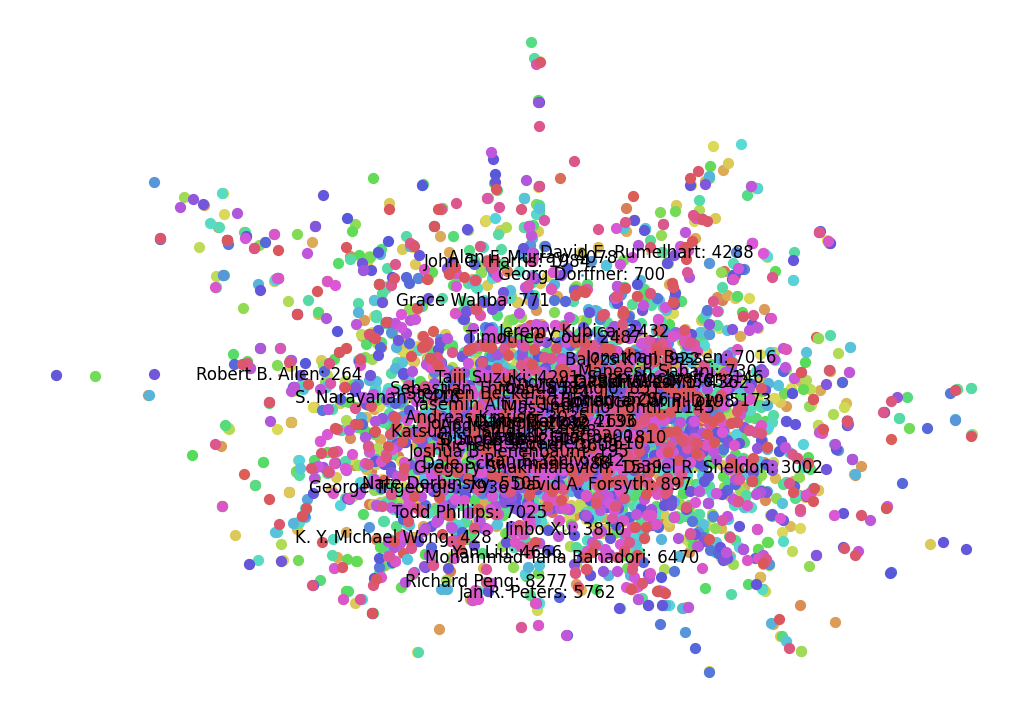

In [221]:
display_graph(G, clusters, big_clusters)

# Approach 2: Normalized spectral clustering according to Shi and Malik

Input: Similarity matrix S ∈ n×n, number k of clusters to construct.
- Construct a similarity graph. Let $W$ be its weighted adjacency matrix.
- Compute the unnormalized Laplacian $L$.
- Compute the first $k$ generalized eigenvectors $u_1,...,u_k$ of the generalized eigenproblem $Lu = λDu$.
- Let $U ∈ n×k$ be the matrix containing the vectors $u_1,...,u_k$ as columns.
- For $i = 1,...,n$, let $y_i ∈ k$ be the vector corresponding to the i-th row of $U$.
- Cluster the points $(y_i)i=1,...,n$ in $k$ with the k-means algorithm into clusters $C_1,...,C_k$. </br></br>
Output: Clusters $A_1,...,A_k$ with $A_i = \{j| y_j ∈ C_i\}$.

In [9]:
def create_similarity_matrix():
    W = np.diag(np.ones(len(authors.keys())))
    num_edges = 0
    for paper, authors_ in paper_authors.items():
        if len(authors_) >= 2:
            for i1, i2 in itertools.permutations(authors_, 2):
                if W[i1, i2] > 0:
                    W[i1, i2] *= 2
                else:
                    W[i1, i2] = 1
                num_edges += 1

    return W

def create_unnormalized_laplacian(W):
    degree_values = np.sum(W, axis=1)
    D = np.diag(degree_values)
    L = D - W
    return L, D

def compute_U_matrix(L, D, k):
    eigenvalues, eigenvectors = linalg.eig(L, D)

    U = eigenvectors[:, :k]

    return U

def get_y_vectors(U):
    y_vectors = []
    for i in range(U.shape[0]):
        y_i = U[i, :]
        y_vectors.append(y_i)
        
    return np.array(y_vectors)

def cluster_points_kmeans(y_vectors, k):
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(y_vectors)

    return clusters

In [9]:
k = 1000
W = create_similarity_matrix()
L, D = create_unnormalized_laplacian(W)

In [10]:
U = compute_U_matrix(L, D, k)
y_vectors = get_y_vectors(U)

## Cluster with KMeans

In [11]:
clusters = cluster_points_kmeans(y_vectors, k)

In [12]:
cluster_lens = np.empty(k)

for i in range(k):
    cluster_lens[i] = len(np.where(clusters == i)[0])

max(cluster_lens), min(cluster_lens), np.mean(cluster_lens)

(462.0, 0.0, 8.653)

In [13]:
G = nx.Graph(W)

In [14]:
big_clusters = np.where(cluster_lens > 30)
big_clusters

(array([  0,  30,  37,  74,  96, 102, 141, 350, 495, 503, 513, 597, 631,
        666, 724, 727, 791, 793, 797, 803, 805, 806, 807, 808, 822, 827,
        836, 837, 841, 844, 862, 863, 871, 874, 879, 881, 884, 885, 888,
        928, 929, 935, 941, 945, 946, 953, 972, 977, 978, 979, 982, 986,
        989, 993], dtype=int64),)

Community of  773 (ID  0 ) -  86  authors:
['Mark Craven', 'Giacomo Indiveri', 'Allen M. Waxman', 'Reid R. Harrison', 'Paul Bourgine', 'Fangyu Gao', 'Dong Xiang', 'Yves Grandvalet', 'Tobias Mann', 'Volker Roth', 'Peter N. Steinmetz', 'Chiranjib Bhattacharyya', 'Katya Scheinberg', 'Xiaofeng He', 'Hyeyoung Park', 'J. A. Beintema', 'Michael D. Lee', 'Stan Z. Li', 'Arunava Banerjee', 'D. Philipona', 'Timothy Chiu', 'John C. Pearson', 'Dimah Yanovsky', 'Z. Gao', 'Dustin Lang', 'Nicolas Vayatis', 'Xiaofeng Ren', 'Renaud Jolivet', 'Kristina Klinkner', 'Cosma Shalizi', 'Kyung-ah Sohn', 'Stefan Klampfl', 'Shalabh Bhatnagar', 'Pierre Morizet-mahoudeaux', 'Bharath K. Sriperumbudur', 'Georgios Tziritas', 'Thomas Naselaris', 'Lukas Kroc', 'James M. Bower', 'Holly Jimison', 'Marion Plaze', 'Peter Spirtes', 'Marc Henniges', 'Kai-Yeung Siu', 'Martha White', 'Felipe Gerhard', 'Nawanol Ampornpunt', 'Morten M?rup', 'Wenhao Gui', 'Jacob D. Abernethy', 'Takashi Washio', 'Arthur D. Szlam', 'Andrei B. Ungure

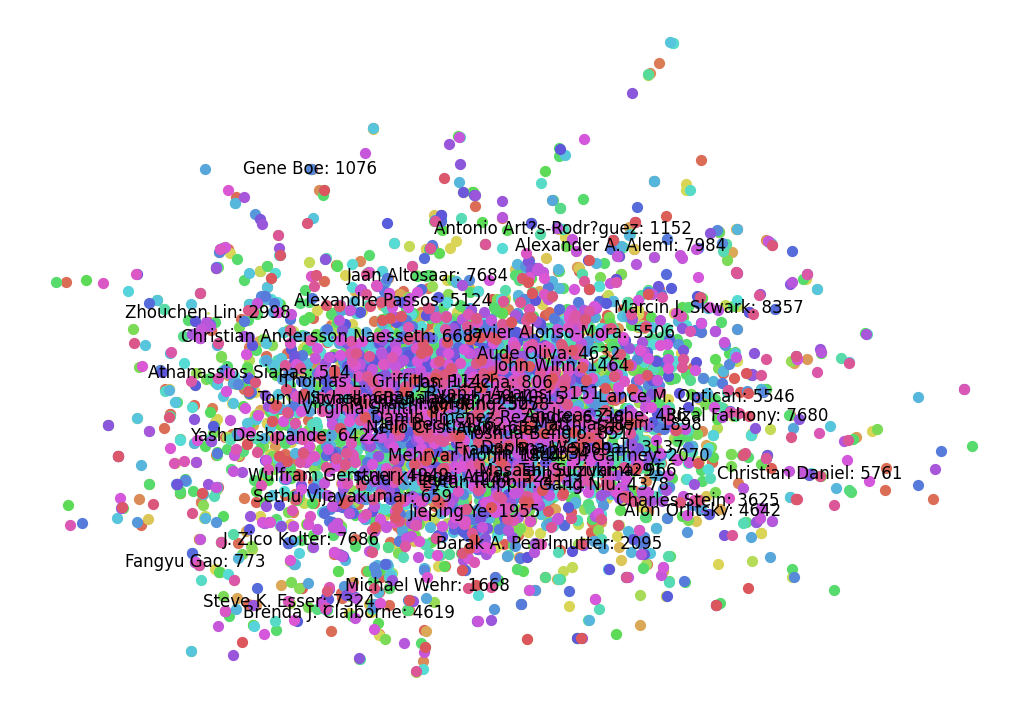

In [17]:
display_graph(G, clusters, big_clusters)

# Approach 3: Normalized spectral clustering according to Ng, Jordan, and Weiss

Input: Similarity matrix S ∈ n×n, number k of clusters to construct.
- Construct a similarity graph. Let $W$ be its weighted adjacency matrix.
- Compute the unnormalized Laplacian $L$.
- Compute the first $k$ eigenvectors $u_1,...,u_k$ of $L_{sym}$.
- Let $U ∈ n×k$ be the matrix containing the vectors $u_1,...,u_k$ as columns.
- Form the matrix $T ∈ n×k$ from $U$ by normalizing the rows to norm 1, that is set $t_{ij} = u_{ij}/(\Sigma_k u^2_{ik})^{1/2}$.
- For $i = 1,...,n$, let $y_i ∈ k$ be the vector corresponding to the i-th row of $T$.
- Cluster the points $(y_i)i=1,...,n$ in $k$ with the k-means algorithm into clusters $C_1,...,C_k$. </br></br>
Output: Clusters $A_1,...,A_k$ with $A_i = \{j| y_j ∈ C_i\}$.

In [25]:
def create_similarity_matrix():
    W = np.diag(np.ones(len(authors.keys())))
    num_edges = 0
    for paper, authors_ in paper_authors.items():
        if len(authors_) >= 2:
            for i1, i2 in itertools.permutations(authors_, 2):
                if W[i1, i2] > 0:
                    W[i1, i2] *= 2
                else:
                    W[i1, i2] = 1
                num_edges += 1

    return W

def create_unnormalized_laplacian(W):
    degree_values = np.sum(W, axis=1)
    D = np.diag(degree_values)
    L = D - W
    return L, D

def compute_U_matrix_sym(L, D, k):
    D_inverse_sqrt = np.linalg.inv(np.sqrt(D))
    L_sym = D_inverse_sqrt @ L @ D_inverse_sqrt
    eigenvalues, eigenvectors = np.linalg.eigh(L_sym)

    U = eigenvectors[:, :k]
    return U

def normalize_U(U):
    return U / np.linalg.norm(U, axis=1, keepdims=True)

def get_y_vectors(U):
    T = U
    return T

def cluster_points_kmeans(y_vectors, k):
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(y_vectors)
    return clusters

In [19]:
k = 1000
W = create_similarity_matrix()
L, D = create_unnormalized_laplacian(W)

In [26]:
U = compute_U_matrix_sym(L, D, k)
T = normalize_U(U)
y_vectors = get_y_vectors(T)

## Cluster with KMeans

In [27]:
clusters = cluster_points_kmeans(y_vectors, k)

In [28]:
cluster_lens = np.empty(k)

for i in range(k):
    cluster_lens[i] = len(np.where(clusters == i)[0])

max(cluster_lens), min(cluster_lens), np.mean(cluster_lens)

(183.0, 1.0, 8.653)

In [29]:
G = nx.Graph(W)

In [30]:
big_clusters = np.where(cluster_lens > 30)
big_clusters

(array([ 13,  16,  23,  27,  28,  31,  36,  42,  44,  45,  47,  50,  66,
         73,  85, 108, 120, 121, 124, 126, 128, 129, 163, 203, 234, 237,
        254, 256, 298, 397, 501, 531, 607, 632, 939, 986, 998], dtype=int64),)

Community of  730 (ID  13 ) -  44  authors:
['Maneesh Sahani', 'John S. Pezaris', 'Richard A. Andersen', 'Jennifer F. Linden', 'Gregoire Deback', 'Vincent Bonin', 'Valerio Mante', 'Matteo Carandini', 'Afsheen Afshar', 'Gopal Santhanam', 'Stephen I. Ryu', 'Byron M. Yu', 'Krishna V. Shenoy', 'Misha Ahrens', 'Lars Buesing', 'John P. Cunningham', 'Richard Turner', 'J?rg L?cke', 'Marc Henniges', 'Andrew Wilson', 'Biljana Petreska', 'Marius Pachitariu', 'Srini Turaga', 'Adam M. Packer', 'Henry Dalgleish', 'Noah Pettit', 'Michael Hausser', 'Jakob Macke', 'Zhenwen Dai', 'Georgios Exarchakis', 'Timothy A. Machado', 'Elad Gilboa', 'Arye Nehorai', 'William E. Bishop', 'Zoltan Szabo', 'Yuanjun Gao', 'Lars Busing', 'Wittawat Jitkrittum', 'Ahmad Qamar', 'Abdul-Saboor Sheikh', 'Nicholas A. Steinmetz', 'Shabnam N. Kadir', 'Kenneth D. Harris', 'Travis Monk'] 

Community of  1079 (ID  16 ) -  40  authors:
['Gustavo Deco', 'Wilfried Brauer', 'Laura Martignon', 'Kathryn B. Laskey', 'Michael Schmitt', 'Jos

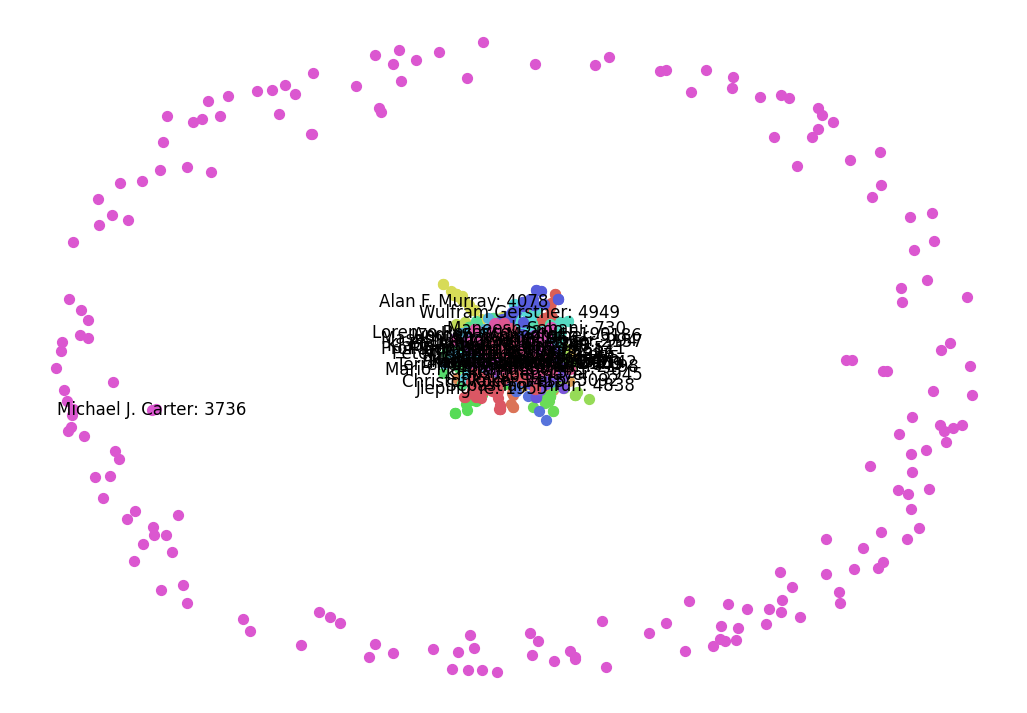

In [31]:
display_graph(G, clusters, big_clusters)